In [1013]:
from IPython.display import display, HTML
display(HTML("<style>:root {--jp-notebook-max-width: 3000px;}</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1014]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 기계학습 (60점)

### 2023년도 NBA 농구 슛 시도 관련 데이터
data_path = './data/nba.csv'

NBA 각 경기에서 발생한 슛 시도 관련 데이터이다.     
자유튜(1점)은 없고 각 경기의 승패는 2,3점의 총 합으로 결정된다고 가정한다.

TEAM_NAME : 팀명     
PLAYER_ID : 슛을 쏜 선수    
POSITION_GROUP : 포지션    
GAME_ID : 게임명     
SHOT_MADE : 슛 성공여부 (True : 성공 ,False : 실패)     
ACTION_TYPE : 슛 종류     
SHOT_TYPE : 점수 (2점,3점)    
ZONE_ABB : 점수 존     
LOC_X : 슛을 쏜 x 좌표     
LOC_Y : 슛을 쏜 y 좌표      
QUARTER : 쿼터 (정규경기 4쿼터까지 쿼터당 12분)    
MINS_LEFT : 쿼터의 잔여 시간 (분)    
SECS_LEFT : 쿼터의 잔여 시간 (초)     

In [1017]:
import pandas as pd
df =pd.read_csv('./data/nba.csv')
df.head()

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT
0,team_5,player_1,G,22300003,False,Driving Floating Jump Shot,2PT Field Goal,C,-0.4,17.45,1,11,1
1,team_5,player_2,F,22300003,True,Jump Shot,3PT Field Goal,C,1.5,30.55,1,10,26
2,team_5,player_3,G,22300003,True,Driving Layup Shot,2PT Field Goal,C,-3.3,6.55,1,9,46
3,team_5,player_1,G,22300003,True,Running Finger Roll Layup Shot,2PT Field Goal,C,-1.0,5.85,1,8,30
4,team_5,player_3,G,22300003,True,Cutting Layup Shot,2PT Field Goal,C,-0.0,6.25,1,8,8


### 기계학습1
아래의 기준으로 파생변수 3개를 만들어라 
- shot_distance (슛거리)     : LOC_X, LOX_Y 좌표의 제곱합에 루트를 씌운다
- net_play_time (경기경과시간) : 슛을 시도한 시점의 순 경기 시간을 초(sec)단위로 구한다. 쉬는시간은 고려하지 않는다. 4쿼터 종료시점(MINS_LEFT =0, SECS_LEFT=0)에 슛을 시도했다면 2880 값을 가져야 한다. 
- net_score : 해당 게임에 해당팀이 슛을 쏜 결과를 반영한 누적 득점

![imgs](./data/img/p1.png)

In [1020]:
df1 = df.copy()

In [1021]:
df1['shot_distance'] = (df1.LOC_X**2 + df1.LOC_Y**2)**0.5

In [1022]:
df1.loc[207099:207103, 'shot_distance']

207099    32.134600
207100    14.339543
207101     9.768444
207102    34.591798
207103    33.507051
Name: shot_distance, dtype: float64

In [1023]:
df1['net_play_time'] = df1.QUARTER * 12 * 60 - df1.MINS_LEFT * 60 - df1.SECS_LEFT

In [1024]:
df1['score']= df1.SHOT_TYPE.str.split('PT').str[0].astype(int) * df1.SHOT_MADE

In [1025]:
df1['net_score'] = df1.groupby(['TEAM_NAME','GAME_ID']).score.cumsum()

In [1026]:
df1.loc[207099:207103, :]

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT,shot_distance,net_play_time,score,net_score
207099,team_28,player_554,G,22301218,False,Jump Shot,3PT Field Goal,LC,11.9,29.85,4,0,48,32.134600,2832,0,90
207100,team_28,player_556,C,22301218,False,Tip Layup Shot,2PT Field Goal,C,1.6,14.25,4,0,45,14.339543,2835,0,90
207101,team_28,player_556,C,22301218,True,Jump Shot,2PT Field Goal,C,0.6,9.75,4,0,44,9.768444,2836,2,92
207102,team_28,player_552,G,22301218,True,Pullup Jump shot,3PT Field Goal,C,-1.7,34.55,4,0,37,34.591798,2843,3,95
207103,team_28,player_552,G,22301218,False,Pullup Jump shot,3PT Field Goal,RC,-11.0,31.65,4,0,30,33.507051,2850,0,95


### 기계학습2
데이터 EDA를 실시하라 (시각화 포함)

- POSITION_GROUP에 결측치가 1195개 존재한다. 다만, 본 분석에서는 POSITION_GROUP을 사용하지 않으므로 따로 처리하지 않는다.
- 수치형변수 중 LOC_X는 가운데를 중심으로 분포하며 LOC_Y, net_score는 오른쪽으로 치우친 분포를 보이고 있다.
- 수치형변수 중 SECS_LEFT, net_play_time 변수는 상대적으로 고른 분포를 보인다.
- 명목형변수 중 ZONE_ABB, ACTION_TYPE은 특정 범주('C', 'jump_shot')가 많은 비중을 차지하고 있다.
- 파생변수와 원 변수를 제외하고, 변수 간 선형 상관관계는 특이점이 보이지 않는다.

In [1029]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207104 entries, 0 to 207103
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TEAM_NAME       207104 non-null  object 
 1   PLAYER_ID       207104 non-null  object 
 2   POSITION_GROUP  205909 non-null  object 
 3   GAME_ID         207104 non-null  int64  
 4   SHOT_MADE       207104 non-null  bool   
 5   ACTION_TYPE     207104 non-null  object 
 6   SHOT_TYPE       207104 non-null  object 
 7   ZONE_ABB        207104 non-null  object 
 8   LOC_X           207104 non-null  float64
 9   LOC_Y           207104 non-null  float64
 10  QUARTER         207104 non-null  int64  
 11  MINS_LEFT       207104 non-null  int64  
 12  SECS_LEFT       207104 non-null  int64  
 13  shot_distance   207104 non-null  float64
 14  net_play_time   207104 non-null  int64  
 15  score           207104 non-null  int32  
 16  net_score       207104 non-null  int32  
dtypes: bool(1)

In [1030]:
df1.isnull().sum()

TEAM_NAME            0
PLAYER_ID            0
POSITION_GROUP    1195
GAME_ID              0
SHOT_MADE            0
ACTION_TYPE          0
SHOT_TYPE            0
ZONE_ABB             0
LOC_X                0
LOC_Y                0
QUARTER              0
MINS_LEFT            0
SECS_LEFT            0
shot_distance        0
net_play_time        0
score                0
net_score            0
dtype: int64

In [1031]:
df1.describe()

,GAME_ID,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT,shot_distance,net_play_time,score,net_score
count,2.071040e+05,207104.000000,207104.000000,207104.000000,207104.000000,207104.000000,207104.000000,207104.000000,207104.000000,207104.000000
mean,2.230062e+07,0.169229,14.662257,2.468489,5.396313,28.887680,18.145790,1424.645811,1.094595,49.299864
std,3.552095e+02,11.432008,9.448406,1.116607,3.447973,17.390197,10.281215,829.900036,1.193722,29.407562
min,2.230000e+07,-25.000000,0.150000,1.000000,0.000000,0.000000,0.269258,3.000000,0.000000,0.000000
25%,2.230031e+07,-4.500000,6.650000,1.000000,2.000000,14.000000,7.742254,701.000000,0.000000,24.000000
50%,2.230062e+07,-0.000000,10.550000,2.000000,5.000000,29.000000,16.788761,1416.000000,0.000000,49.000000
75%,2.230092e+07,4.800000,23.150000,3.000000,8.000000,44.000000,29.149142,2137.000000,2.000000,73.000000
max,2.230123e+07,25.000000,89.450000,4.000000,11.000000,59.000000,89.843545,2880.000000,3.000000,149.000000


In [1032]:
df1.describe(include = 'object')

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,ACTION_TYPE,SHOT_TYPE,ZONE_ABB
count,207104,207104,205909,207104,207104,207104
unique,30,568,3,48,2,6
top,team_1,player_454,G,Jump Shot,2PT Field Goal,C
freq,7500,1631,90181,59883,125335,117614


In [1033]:
df1.GAME_ID = df1.GAME_ID.astype(object)

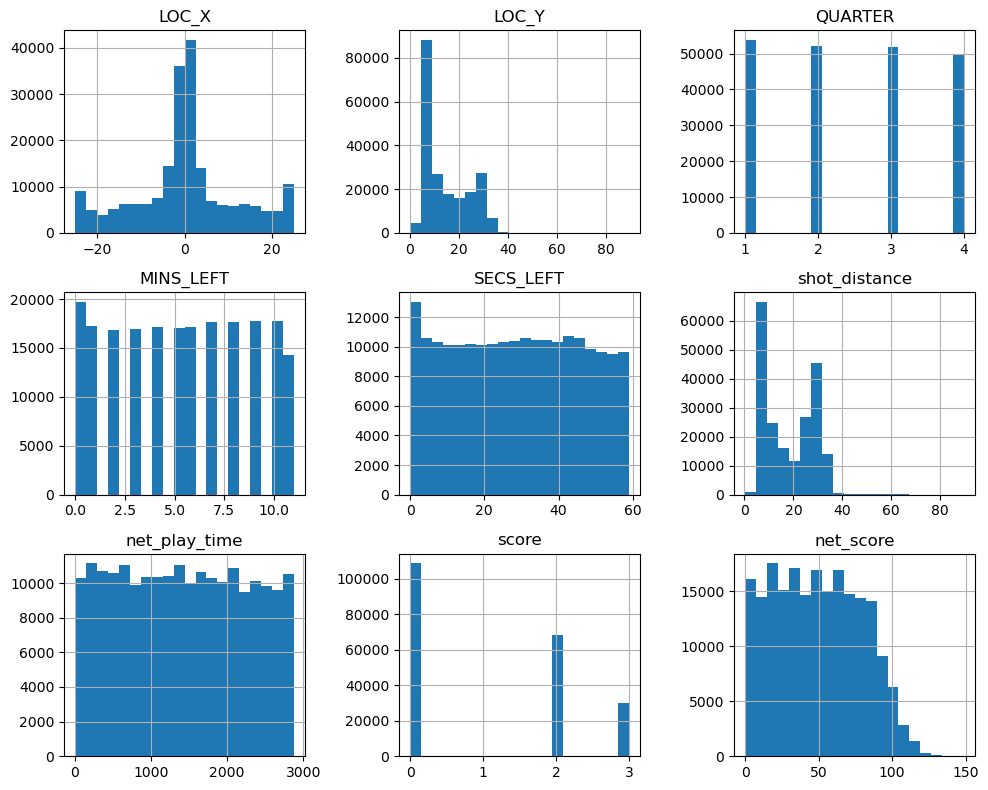

In [1034]:
df1.select_dtypes(include = 'number').hist(bins = 20, figsize = (10, 8))
plt.tight_layout()
plt.show()

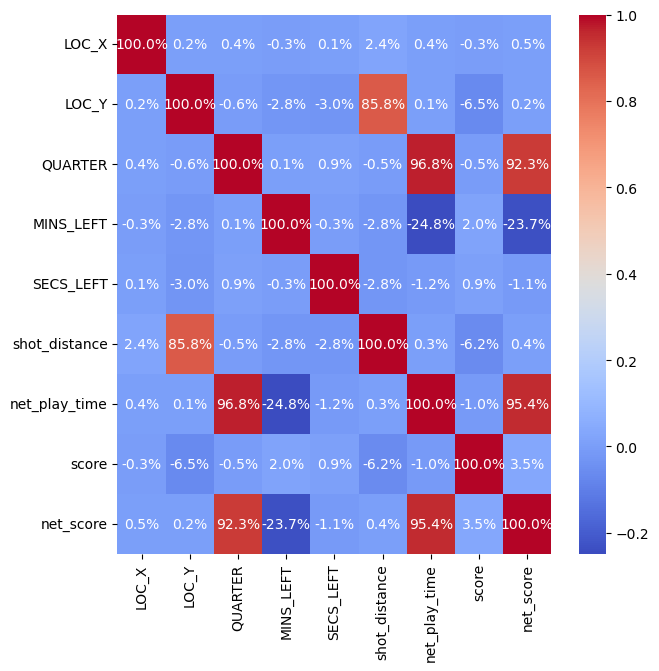

In [1035]:
plt.figure(figsize = (7, 7))
sns.heatmap(df1.select_dtypes(include = 'number').corr(), annot = True, fmt = '.1%', cmap = 'coolwarm')
plt.show()

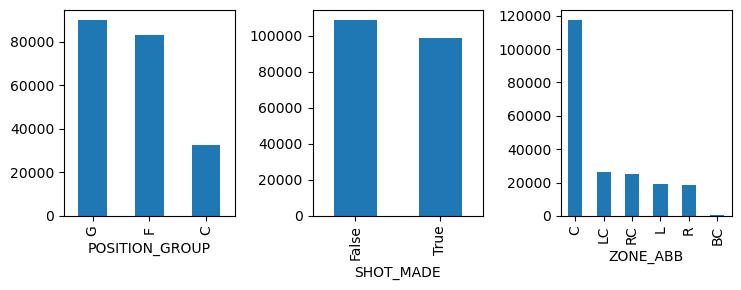

In [1036]:
obj_col = ['POSITION_GROUP', 'SHOT_MADE', 'ZONE_ABB']        

plt.figure(figsize = (10, 3))
for i in range(len(obj_col)):
    plt.subplot(1, 4, i+1)
    df1[obj_col[i]].value_counts().plot(kind = 'bar')

plt.tight_layout()
plt.show()

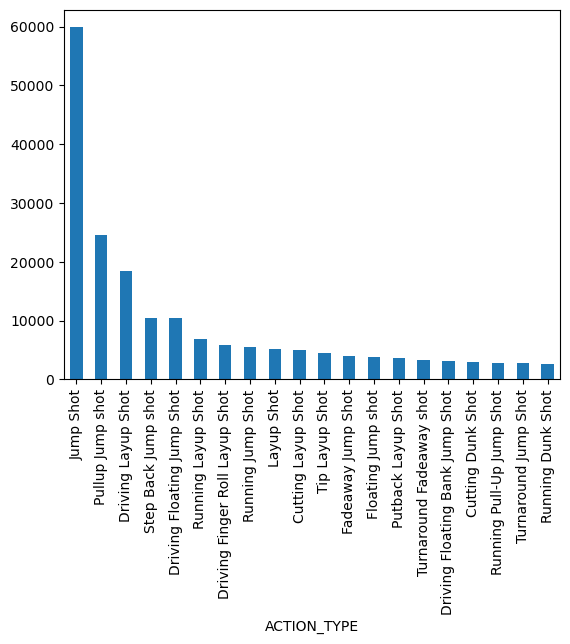

In [1037]:
df1.ACTION_TYPE.value_counts()[:20].plot(kind = 'bar')
plt.show()

### 기계학습3     
3쿼터까지의 데이터를 바탕으로 승부를 예측하는 분류 모델을 만들려고 한다.
데이터를 아래 기준으로 전처리 진행한다.

- 각 행은 하나의 팀, 하나의 게임 아이디에 대한 정보를 나타낸다.
- 각 쿼터(1~3쿼터)를 6분간격으로 두 구간으로 나누어 새로운 파생변수를 만든다.      
    - 1_1_ratio (1쿼터의 0~6분)의 (2점 실패 횟수 / 2점 시도 횟수) , (3점 실패 횟수 / 3점 시도 횟수)
    - 1_2_ratio (1쿼터의 6~12분)의 (2점 실패 횟수 / 2점 시도 횟수) , (3점 실패 횟수 / 3점 시도 횟수)
    - ~ 3쿼터까지 총 6구간에 대해 12개의 컬럼
- 해당 게임의 팀별 1쿼터까지 득점, 3쿼터까지의 총 득점(2,3점) (총 2개컬럼, 1_q_score , 3_q_score)
- 4쿼터 후 최종 승패여부(result) (승 : 1 , 패 :0 ) - 자유투는 없다고 가정, 2,3점 만으로 게임의 승부를 결정, 승부가 결정나지 않은 게임은 없다

![img](./data/img/p2.png)

- 쿼터별 점수별 실패비율

In [1041]:
df1.head()

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT,shot_distance,net_play_time,score,net_score
0,team_5,player_1,G,22300003,False,Driving Floating Jump Shot,2PT Field Goal,C,-0.4,17.45,1,11,1,17.454584,59,0,0
1,team_5,player_2,F,22300003,True,Jump Shot,3PT Field Goal,C,1.5,30.55,1,10,26,30.586803,94,3,3
2,team_5,player_3,G,22300003,True,Driving Layup Shot,2PT Field Goal,C,-3.3,6.55,1,9,46,7.334337,134,2,5
3,team_5,player_1,G,22300003,True,Running Finger Roll Layup Shot,2PT Field Goal,C,-1.0,5.85,1,8,30,5.934855,210,2,7
4,team_5,player_3,G,22300003,True,Cutting Layup Shot,2PT Field Goal,C,-0.0,6.25,1,8,8,6.250000,232,2,9


In [1042]:
df1.loc[df1.MINS_LEFT >= 6, 'half'] = 'first'
df1.loc[df1.MINS_LEFT < 6, 'half'] = 'last'

In [1043]:
target_total = df1.loc[(df1.SHOT_TYPE.isin(['2PT Field Goal','3PT Field Goal'])) & (df1.QUARTER <= 3)]

In [1044]:
total = target_total.groupby(['GAME_ID','TEAM_NAME','QUARTER','half','SHOT_TYPE']).size().unstack(-3).unstack(-2).unstack(-1).fillna(0)
total

QUARTER                         1                                \
half                        first                          last   
SHOT_TYPE          2PT Field Goal 3PT Field Goal 2PT Field Goal   
GAME_ID  TEAM_NAME                                                
22300001 team_1               8.0            6.0            9.0   
         team_2               9.0            3.0            7.0   
22300002 team_3              10.0            5.0           10.0   
         team_4               6.0            3.0            8.0   
22300003 team_5               5.0            4.0            3.0   
...                           ...            ...            ...   
22301228 team_27              7.0            7.0            5.0   
22301229 team_1               9.0            3.0           10.0   
         team_4               8.0            4.0           10.0   
22301230 team_19              9.0            3.0            9.0   
         team_26              6.0            3.0            6.0   

QUARTER                                        2                 \
half                                       first                  
SHOT_TYPE          3PT Field Goal 2PT Field Goal 3PT Field Goal   
GAME_ID  TEAM_NAME                                                
22300001 team_1               2.0            5.0            3.0   
         team_2               4.0            7.0            4.0   
22300002 team_3               5.0            1.0            6.0   
         team_4               4.0            6.0            8.0   
22300003 team_5               5.0           12.0            1.0   
...                           ...            ...            ...   
22301228 team_27              5.0            5.0            7.0   
22301229 team_1               3.0           12.0            1.0   
         team_4               3.0           10.0            1.0   
22301230 team_19              6.0            8.0            2.0   
         team_26              4.0            6.0            8.0   

QUARTER                                                       3  \
half                         last                         first   
SHOT_TYPE          2PT Field Goal 3PT Field Goal 2PT Field Goal   
GAME_ID  TEAM_NAME                                                
22300001 team_1               8.0            5.0            7.0   
         team_2               6.0            5.0            8.0   
22300002 team_3               9.0            5.0            4.0   
         team_4               4.0            3.0            3.0   
22300003 team_5               5.0            4.0            8.0   
...                           ...            ...            ...   
22301228 team_27             10.0            4.0            8.0   
22301229 team_1               3.0            9.0            5.0   
         team_4               6.0            4.0            2.0   
22301230 team_19              5.0            5.0            8.0   
         team_26              6.0            6.0            5.0   

QUARTER                                                          
half                                        last                 
SHOT_TYPE          3PT Field Goal 2PT Field Goal 3PT Field Goal  
GAME_ID  TEAM_NAME                                               
22300001 team_1               3.0            7.0            5.0  
         team_2               1.0            7.0            3.0  
22300002 team_3               7.0            6.0            5.0  
         team_4               6.0            8.0            6.0  
22300003 team_5               3.0            5.0            4.0  
...                           ...            ...            ...  
22301228 team_27              2.0            8.0            4.0  
22301229 team_1               7.0            8.0            4.0  
         team_4               9.0           13.0            1.0  
22301230 team_19              4.0            8.0            4.0  
         team_26              4.0            7.0          

In [1045]:
target_fail = df1.loc[(df1.SHOT_TYPE.isin(['2PT Field Goal','3PT Field Goal'])) & (df1.QUARTER <= 3) & (df1.SHOT_MADE == False)]
target_fail

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT,shot_distance,net_play_time,score,net_score,half
0,team_5,player_1,G,22300003,False,Driving Floating Jump Shot,2PT Field Goal,C,-0.4,17.45,1,11,1,17.454584,59,0,0,first
11,team_5,player_5,F,22300003,False,Jump Shot,3PT Field Goal,RC,-10.9,29.15,1,3,58,31.121255,482,0,25,last
13,team_5,player_4,F,22300003,False,Driving Floating Jump Shot,2PT Field Goal,C,0.4,11.55,1,1,54,11.556924,606,0,27,last
16,team_5,player_4,F,22300003,False,Jump Shot,3PT Field Goal,C,-0.2,39.25,1,0,1,39.250510,719,0,33,last
17,team_5,player_4,F,22300003,False,Fadeaway Jump Shot,2PT Field Goal,C,0.9,21.05,2,11,34,21.069231,746,0,33,first
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207076,team_28,player_561,G,22301218,False,Turnaround Jump Shot,2PT Field Goal,C,5.6,9.35,3,2,24,10.898738,2016,0,77,last
207078,team_28,player_554,G,22301218,False,Jump Shot,3PT Field Goal,RC,-12.5,32.45,3,1,55,34.774308,2045,0,79,last
207079,team_28,player_560,C,22301218,False,Turnaround Hook Shot,2PT Field Goal,C,0.4,15.25,3,1,22,15.255245,2078,0,79,last
207080,team_28,player_305,G,22301218,False,Jump Shot,3PT Field Goal,R,-22.5,6.95,3,0,52,23.548938,2108,0,79,last


In [1046]:
fail = target_fail.groupby(['GAME_ID','TEAM_NAME','QUARTER','half', 'SHOT_TYPE']).size().unstack(-3).unstack(-2).unstack(-1).fillna(0)
fail

QUARTER                         1                                \
half                        first                          last   
SHOT_TYPE          2PT Field Goal 3PT Field Goal 2PT Field Goal   
GAME_ID  TEAM_NAME                                                
22300001 team_1               5.0            2.0            3.0   
         team_2               5.0            2.0            2.0   
22300002 team_3               7.0            3.0            7.0   
         team_4               1.0            1.0            6.0   
22300003 team_5               1.0            0.0            1.0   
...                           ...            ...            ...   
22301228 team_27              3.0            7.0            1.0   
22301229 team_1               2.0            2.0            6.0   
         team_4               4.0            1.0            6.0   
22301230 team_19              5.0            2.0            5.0   
         team_26              2.0            1.0            3.0   

QUARTER                                        2                 \
half                                       first                  
SHOT_TYPE          3PT Field Goal 2PT Field Goal 3PT Field Goal   
GAME_ID  TEAM_NAME                                                
22300001 team_1               1.0            3.0            1.0   
         team_2               3.0            3.0            2.0   
22300002 team_3               3.0            0.0            5.0   
         team_4               4.0            4.0            3.0   
22300003 team_5               2.0            6.0            1.0   
...                           ...            ...            ...   
22301228 team_27              3.0            4.0            4.0   
22301229 team_1               3.0            5.0            1.0   
         team_4               3.0            6.0            1.0   
22301230 team_19              3.0            6.0            1.0   
         team_26              2.0            2.0            4.0   

QUARTER                                                       3  \
half                         last                         first   
SHOT_TYPE          2PT Field Goal 3PT Field Goal 2PT Field Goal   
GAME_ID  TEAM_NAME                                                
22300001 team_1               2.0            3.0            4.0   
         team_2               1.0            5.0            3.0   
22300002 team_3               7.0            3.0            0.0   
         team_4               4.0            0.0            3.0   
22300003 team_5               2.0            4.0            3.0   
...                           ...            ...            ...   
22301228 team_27              6.0            3.0            4.0   
22301229 team_1               0.0            6.0            2.0   
         team_4               2.0            3.0            0.0   
22301230 team_19              0.0            4.0            5.0   
         team_26              4.0            3.0            2.0   

QUARTER                                                          
half                                        last                 
SHOT_TYPE          3PT Field Goal 2PT Field Goal 3PT Field Goal  
GAME_ID  TEAM_NAME                                               
22300001 team_1               3.0            4.0            3.0  
         team_2               1.0            1.0            1.0  
22300002 team_3               6.0            0.0            5.0  
         team_4               3.0            4.0            3.0  
22300003 team_5               3.0            1.0            1.0  
...                           ...            ...            ...  
22301228 team_27              1.0            2.0            1.0  
22301229 team_1               6.0            1.0            3.0  
         team_4               3.0            7.0            1.0  
22301230 team_19              4.0            5.0            3.0  
         team_26              2.0            1.0          

In [1047]:
col_lst = []
for i in [1, 2, 3]:
    for j in [1, 2]:
        for k in [2, 3]:
            col_lst.append(f'{i}_{j}_try_{k}')

In [1048]:
result = (fail/total).reset_index()
result.columns = ['GAME_ID', 'TEAM_NAME'] + col_lst

In [1049]:
result = result.sort_values(by = ['GAME_ID','TEAM_NAME'])

In [1050]:
target_score = df1.groupby(['GAME_ID','TEAM_NAME','QUARTER'], as_index = False).score.sum()
target_score

,GAME_ID,TEAM_NAME,QUARTER,score
0,22300001,team_1,1,33
1,22300001,team_1,2,28
2,22300001,team_1,3,18
3,22300001,team_1,4,26
4,22300001,team_2,1,24
...,...,...,...,...
9363,22301230,team_19,4,12
9364,22301230,team_26,1,26
9365,22301230,team_26,2,33
9366,22301230,team_26,3,30


- 해당 게임의 팀별 1쿼터까지 득점, 3쿼터까지의 총 득점(2,3점

In [1052]:
score1 = target_score.loc[target_score.QUARTER == 1].sort_values(by = ['GAME_ID','TEAM_NAME']).reset_index(drop = True)
score3 = target_score.loc[target_score.QUARTER <= 3].groupby(['GAME_ID','TEAM_NAME'], as_index = False).score.sum().sort_values(by = ['GAME_ID','TEAM_NAME']).reset_index(drop = True)

- 4쿼터 후 최종 승패여부(result) (승 : 1 , 패 :0 ) - 자유투는 없다고 가정, 2,3점 만으로 게임의 승부를 결정, 승부가 결정나지 않은 게임은 없다

In [1054]:
target_result = df1.groupby(['GAME_ID','TEAM_NAME'], as_index = False).score.sum()
target_result['max_score'] = target_result.groupby(['GAME_ID'], as_index = False).score.transform('max')
target_result = target_result.sort_values(by = ['GAME_ID','TEAM_NAME'])

- 테이블 병합

In [1056]:
result['1_q_score'] = score1['score']

In [1057]:
result['3_q_score'] = score3['score']

In [1058]:
result_win = (target_result.score == target_result.max_score) * 1

In [1059]:
result.insert(loc = 2, column = 'result', value = result_win)

In [1095]:
result.head()

,GAME_ID,TEAM_NAME,result,1_1_try_2,1_1_try_3,1_2_try_2,1_2_try_3,2_1_try_2,2_1_try_3,2_2_try_2,2_2_try_3,3_1_try_2,3_1_try_3,3_2_try_2,3_2_try_3,1_q_score,3_q_score
0,22300001,team_1,1,0.625000,0.333333,0.333333,0.50,0.600000,0.333333,0.250000,0.6,0.571429,1.000000,0.571429,0.600000,33,79
1,22300001,team_2,0,0.555556,0.666667,0.285714,0.75,0.428571,0.500000,0.166667,1.0,0.375000,1.000000,0.142857,0.333333,24,76
2,22300002,team_3,0,0.700000,0.600000,0.700000,0.60,0.000000,0.833333,0.777778,0.6,0.000000,0.857143,0.000000,1.000000,24,62
3,22300002,team_4,1,0.166667,0.333333,0.750000,1.00,0.666667,0.375000,1.000000,0.0,1.000000,0.500000,0.500000,0.500000,20,74
4,22300003,team_5,0,0.200000,0.000000,0.333333,0.40,0.500000,1.000000,0.400000,1.0,0.375000,1.000000,0.200000,0.250000,33,78



### 기계학습4     
game_id가 홀수로 끝나는 경우는 승리팀만, 짝수를 끝나는 경우는 패배팀만 필터한다.     
랜덤포레스트와 xgb를 사용하여 모델링을 진행하라. 데이터의 층화 추출을 통해 70%의 데이터로 학습하고 30% 데이터로 검증하라

In [1097]:
result.GAME_ID = result.GAME_ID.astype(int)

In [1098]:
modeling_df = result.loc[((result.GAME_ID % 2 == 1) & (result.result ==1) | (result.GAME_ID % 2 == 0) & (result.result ==0))].reset_index(drop = True)

In [1099]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [1100]:
X1 = modeling_df.loc[:, '1_1_try_2':]
y1 = modeling_df['result']

In [1101]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size= 0.3, stratify= y1, random_state=42)

- 랜덤포레스트 모델링

In [1103]:
rf_model = RandomForestClassifier()

In [1104]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [1105]:
rf_pred = rf_model.predict(X_test)

- XGBoost 모델링

In [1107]:
xgb_model = XGBClassifier()

In [1108]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1109]:
xgb_pred = xgb_model.predict(X_test)

- F-1 score를 이용해 모델 성능을 검증하고 비교한다.
  - F-1 score는 민감도와 정밀도의 조화평균으로, 데이터 과적합을 고려한 성능 지표이며 높을수록 좋은 성능으로 해석한다.
  - 검증 결과 랜덤포레스트 모델의 성능이 XGBoost보다 근소하게 우수한 것으로 나타난다.

In [1111]:
from sklearn.metrics import f1_score

In [1112]:
rf_f1 = f1_score(y_test, rf_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

In [1113]:
print(f'랜덤포레스트 F-1 score = {rf_f1}, XGBoost F-1 score = {xgb_f1}')

랜덤포레스트 F-1 score = 0.6972972972972973, XGBoost F-1 score = 0.6846361185983828


### 캘리포니아 집값 데이터


MedInc (Median Income): 지역의 중간 소득. 가구의 중간 연간 소득을 나타냅니다.    
HouseAge (House Age): 지역의 평균 주택 연령. 주택이 지어진 지 얼마나 되었는지를 나타냅니다.     
AveRooms (Average Rooms): 지역의 평균 방 개수. 지역 내 집들의 평균 방 개수를 나타냅니다.     
AveBedrms (Average Bedrooms): 지역의 평균 침실 개수. 지역 내 집들의 평균 침실 개수를 나타냅니다.     
Population: 지역의 총 인구 수. 특정 지역 내 인구 수를 나타냅니다.     
AveOccup (Average Occupancy): 지역의 평균 거주 인원 수. 집당 평균 거주 인원 수를 나타냅니다.    
Latitude: 지역의 위도. 지구의 북쪽 또는 남쪽 위치를 나타내는 좌표입니다.       
Longitude: 지역의 경도. 지구의 동쪽 또는 서쪽 위치를 나타내는 좌표입니다.      
MedHouseVal (종속변수) : 집값 (천 달러 단위)

In [1115]:
from sklearn.datasets import fetch_california_housing
cali = fetch_california_housing()
X2,y2=pd.DataFrame(cali.data,columns =cali['feature_names']), pd.DataFrame(cali.target,columns =['MedHouseVal'])
display(X2.head())
display(y2.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


### 기계학습5
데이터 EDA 및 시각화

- X 데이터 중 MedInc, AveRooms, AveBedrms, Population, AveOccup 변수에서 데이터 편중 및 이상치가 확인된다.
- y 데이터 중 MedHouseVal는 값이 5인 이상치가 확인된다.

In [1118]:
display(X2.describe())
display(y2.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


,MedHouseVal
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


In [1119]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [1120]:
y2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedHouseVal  20640 non-null  float64
dtypes: float64(1)
memory usage: 161.4 KB


In [1121]:
df_total = pd.concat([X2, y2])

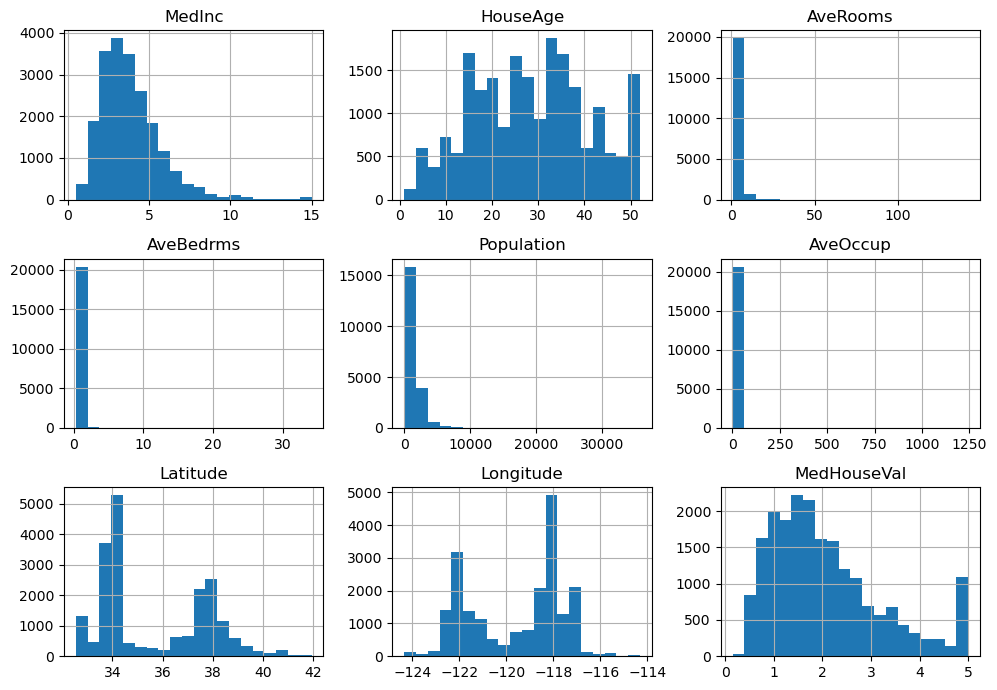

In [1122]:
df_total.hist(bins = 20, figsize = (10, 7))
plt.tight_layout()
plt.show()

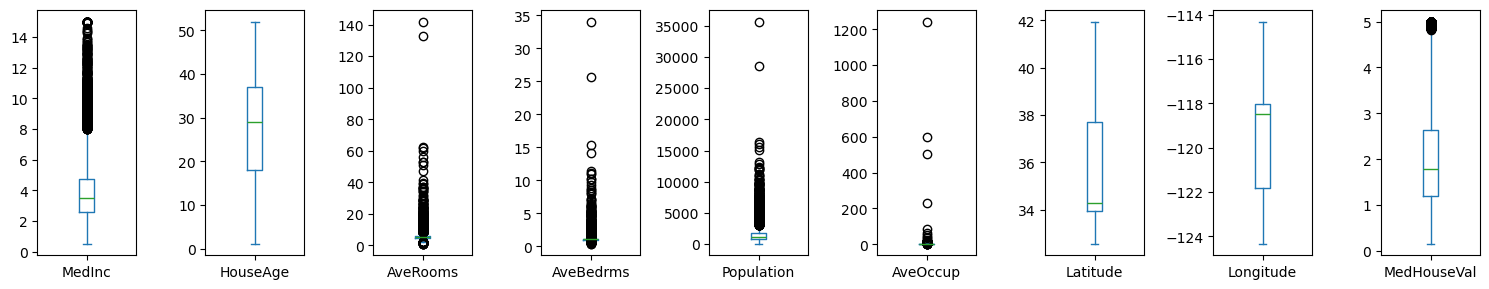

In [1123]:
df_total.plot(kind = 'box', subplots = True, figsize = (15, 3))
plt.tight_layout()

### 기계학습6
변수들의 다중공선성을 검토하라

- 다중공선성은 설명변수 간 상관관계가 존재하여 회귀분석 시 해당 설명변수의 효과를 정확히 파악할 수 없는 문제가 발생하는 것을 의미한다.
- 다중공선성을 파악하기 위해서 주로 한 설명변수와 나머지 설명변수와의 결정계수를 이용한 분산팽창계수(VIF)를 활용하며, VIF가 10을 넘는 경우는 해당 결정계수가 0.9 이상으로 매우 높은 다중공선성이 있는 것으로 진단한다.
- VIF 계산 결과 Longitud, Latitude, AveRooms, AveBedrms, MedInc에 다중공선성이 확인된다.
- 변수 간 상관관계 확인 결과 Latitude - Longitute, AveRooms -AveBedrms 간에 강한 상관관계가 확인되며 해당 두 조합의 한 변수를 제거하면 다중공선성이 해소될 가능성이 있다.

In [1126]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1127]:
vif = pd.DataFrame()

In [1128]:
vif['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(len(X2.columns))]

In [1129]:
vif.index = X2.columns

In [1130]:
vif.sort_values(by = 'VIF', ascending = False)

,VIF
Longitude,633.711654
Latitude,559.874071
AveRooms,45.993601
AveBedrms,43.590314
MedInc,11.511140
HouseAge,7.195917
Population,2.935745
AveOccup,1.095243


In [1131]:
from itertools import combinations

In [1132]:
corr_lst = []
var_name_lst = []

for col1, col2 in combinations(X2, 2):
    corr_lst.append(X2[[col1,col2]].corr().iloc[0,1])
    var_name_lst.append(f'{col1} - {col2}')

In [1133]:
pd.DataFrame(corr_lst, index = var_name_lst, columns = ['corr']).abs().sort_values(by = 'corr', ascending = False)[:10]

,corr
Latitude - Longitude,0.924664
AveRooms - AveBedrms,0.847621
MedInc - AveRooms,0.326895
HouseAge - Population,0.296244
HouseAge - AveRooms,0.153277
MedInc - HouseAge,0.119034
Population - Latitude,0.108785
HouseAge - Longitude,0.108197
AveRooms - Latitude,0.106389
Population - Longitude,0.099773


### 기계학습7     
회귀모델을 제작할 때 다중공선성을 줄이기 위한 방법 3가지를 서술하라

- 변수 축약: 다중공선성이 의심되는 변수를 축약할 수 있다. 주로 주성분분석(PCA) 또는 요인분석(FA)이 사용된다.
- 변수 제거: 다중공선성이 의심되는 변수 중 일부를 제거할 수 있다. 상호 연관되는 변수 중 하나를 제거하면 다중공선성이 해소될 수 있다.
- 정규화 회귀모델: 변수의 가중치를 조정하는 정규화 회귀모델(라쏘, 릿지, 엘라스틱넷 등)을 이용하여 다중공선성을 해소할 수 있다.

### 기계학습8     
훈련용 데이터와 평가용 데이터를 7:3으로 분리한 후, 단순선형회귀모델과 엘라스틱넷모델을 통해 회귀 모델링을 진행하고 rmse값을 기준으로 평가하라. 엘라스틱넷 모델의 경우, 정규화 강도 파라미터를 2가지, l1,l2 페널티를 3가지 방식으로 조정한 모델 총 6개를 만들고 결과에 대해 분석하라

In [1137]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=42)

- 단순선형회귀 모델링

In [1139]:
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

In [1140]:
X_train_add_const = sm.add_constant(X_train)
X_test_add_const = sm.add_constant(X_test)

In [1141]:
ols_model = sm.OLS(y_train, X_train_add_const).fit()

In [1142]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     3023.
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:06:19   Log-Likelihood:                -16912.
No. Observations:               15480   AIC:                         3.384e+04
Df Residuals:                   15471   BIC:                         3.391e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.0278      0.753    -49.164      0.000     -38.504     -35.552
MedInc         0.4476      0.005     92.381      0.000       0.438       0.457
HouseAge       0.0096      0.001     18.709      0.000       0.009       0.011
AveRooms      -0.1248      0.007    -18.280      0.000      -0.138      -0.111
AveBedrms      0.7945      0.034     23.038      0.000       0.727       0.862
Population -1.439e-06    5.4e-06     -0.266      0.790    -1.2e-05    9.15e-06
AveOccup      -0.0034      0.000     -7.061      0.000      -0.004      -0.002
Latitude      -0.4186      0.008    -50.910      0.000      -0.435      -0.402
Longitude     -0.4334      0.009    -50.373      0.000      -0.450      -0.417
==============================================================================
Omnibus:                     3155.561   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9013.135
Skew:                           1.075   Prob(JB):                         0.00
Kurtosis:                       6.058   Cond. No.                     2.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1143]:
ols_pred = ols_model.predict(X_test_add_const)

In [1144]:
ols_rmse = root_mean_squared_error(y_test, ols_pred)

In [1145]:
ols_rmse

0.7356145375446748

- 엘라스틱넷
  - 정규화 강도(alpha)는 0.01, 0.5 / l1 정규항(라쏘)의 비중은 0.3, 0.5, 0.7로 각각 설정하고 모델링 결과
  - alpha는 0.01, l1_ratio는 0.7일 때 rmse가 가장 낮은 것으로(모델 성능이 좋은 것으로) 나타나며, ols보다도 성능이 좋은 것이 확인된다.
    

In [1147]:
from sklearn.linear_model import ElasticNet

In [1148]:
alpha = [0.01, 0.5]
l1_ratio= [0.3, 0.5, 0.7]

In [1149]:
ela_rmse_lst = []
param_comb = []

for al in alpha:
    for l1 in l1_ratio:
        el_model = ElasticNet(alpha = al, l1_ratio=l1)
        el_model.fit(X_train_add_const, y_train)
        el_pred = el_model.predict(X_test_add_const)
        ela_rmse_lst.append(root_mean_squared_error(y_test, el_pred))
        param_comb.append(f'alpha_{al} - l1_ratio_{l1}')

In [1150]:
ela_result_df = pd.DataFrame(ela_rmse_lst, index = param_comb, columns = ['rmse']).sort_values(by = 'rmse', ascending = True)
ela_result_df

,rmse
alpha_0.01 - l1_ratio_0.7,0.729605
alpha_0.01 - l1_ratio_0.5,0.729870
alpha_0.01 - l1_ratio_0.3,0.730198
alpha_0.5 - l1_ratio_0.3,0.814403
alpha_0.5 - l1_ratio_0.5,0.825284
alpha_0.5 - l1_ratio_0.7,0.833998


# 통계 (40점)

### 통계1      
한 제조회사에서는 제품의 품질을 보장하기 위해 생산 라인에서 무작위로 10개의 제품을 샘플링하여 품질 검사를 실시한다. 이때, 제품이 불량일 확률은 23%다.

(1) 적어도 3개의 제품이 불량일 확률은?
(2) 2개 이하의 제품이 불량일 확률은?

- 독립인 반복시행 시 성공 횟수에 대한 확률을 구하므로 이항분포를 이용한다.

In [1154]:
from scipy.stats import binom

In [1155]:
rv = binom(n = 10, p = 0.23)

In [1156]:
p_1 = 1 - rv.cdf(2)
p_2 = rv.cdf(2)

In [1157]:
print(f'(1) 적어도 3개의 제품이 불량일 확률 : {p_1}')
print(f'(2) 2개 이하의 제품이 불량일 확률 : {p_2}')

(1) 적어도 3개의 제품이 불량일 확률 : 0.4137172738381183
(2) 2개 이하의 제품이 불량일 확률 : 0.5862827261618817


### 통계2
어느 고객 서비스 센터에는 센터에는 평균적으로 1분에 3건의 전화가 걸려온다. 전화 빈도는 아래와 같은 조건을 가진다.
전화가 걸려오는 사건이 독립적이다.
특정 시간 동안에 전화가 걸려올 확률이 일정하다.
단위 시간 내에 동시에 두 개 이상의 전화가 걸려올 확률은 매우 낮다.

(1) 10분 동안 전화가 23통 이하로 걸려올 확률은?
(2) 10분 동안 전화가 정확히 30통 걸려올 확률은?

- 단위기간 내 독립시행이면서 발생 확률이 낮으므로 이항분포의 포아송 근사를 이용한다.
- 단위기간은 10분으로 설정하고 평균은 3 * 10 = 30으로 설정한다.

In [1160]:
from scipy.stats import poisson

In [1161]:
rv = poisson(mu = 30)

In [1162]:
p_1 = rv.cdf(23)
p_2 = rv.pmf(30)

In [1163]:
print(f'(1) 10분 동안 전화가 23통 이하로 걸려올 확률 = {p_1}')
print(f'(2) 10분 동안 전화가 정확히 30통 걸려올 확률 = {p_2}')

(1) 10분 동안 전화가 23통 이하로 걸려올 확률 = 0.11464591271427384
(2) 10분 동안 전화가 정확히 30통 걸려올 확률 = 0.07263452647159181


### 통계 3    
한 회사에서 직원들의 근무 만족도가 개선되었는지를 평가하기 위해, 직원들에게 개선 전과 개선 후의 만족도를 각각 설문조사했다. 만족도 점수는 1에서 10까지의 범위로 측정된다. 다음은 10명의 직원이 제공한 만족도 점수다

개선 전: [5, 6, 7, 5, 6, 8, 7, 5, 6, 9]      
개선 후: [6, 7, 8, 6, 7, 9, 8, 6, 7, 10]

### 통계 3-1
개선 전후의 만족도가 유의미하게 변화했는지 검정하려한다. 귀무가설과 대립가설을 설정하라

- 귀무가설 : 개선 전과 후의 직원들의 근무 만족도에 차이가 없다.
- 대립가설 : 개선 전에 비해 개선 후 직원들의 근무 만족도가 높다.

### 통계 3-2
통계검정을 실시하고 검정통계량과 pvalue값을 구하라. 결과를 분석하라

- 본 표본은 동일한 표본에 대해 특정 시간 차이로 측정하였으므로 대응표본에 해당된다.
- 모수적 방법 이용 가능여부 확인을 위해 차이의 shapiro 및 콜모고로프-스미르노프(ks) 검정을 통해 정규성 준수여부를 확인한다.
- 검정 결과 차이의 데이터가 모두 1로 구성되어있어 검정 통계량을 이용한 검정이 불가한 것이 확인된다.
- 다만, 데이터가 1인 경우 정규분포보다 균등분포에 가까우므로 모수적 방법 대신 비모수적 방법인 윌콕슨 부호순위검정을 이용하여 검정을 실시한다.

In [1169]:
before = np.array([5, 6, 7, 5, 6, 8, 7, 5, 6, 9])
after = np.array([6, 7, 8, 6, 7, 9, 8, 6, 7, 10])

In [1170]:
d = after - before

In [1171]:
d

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1172]:
from scipy.stats import shapiro

In [1173]:
shapiro(d)

C:\Users\user\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=1.0, pvalue=1.0)

In [1174]:
from scipy.stats import kstest

In [1175]:
from scipy.stats import norm

In [1176]:
rv_norm = norm(loc = d.mean(), scale = d.std())

In [1177]:
kstest(d, cdf = rv_norm.cdf)

C:\Users\user\anaconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


KstestResult(statistic=nan, pvalue=nan, statistic_location=1, statistic_sign=-1)

- 윌콕슨 부호순위검정

In [1179]:
from scipy.stats import wilcoxon

In [1180]:
statistic, p_value = wilcoxon(after, before, alternative='greater')

In [1181]:
print(f'검정 결과 통계량의 p_value는 {p_value}로 유의수준 0.05 미만이다. 따라서 귀무가설을 기각한다.')
print(f'즉, 개선 전에 비해 개선 후 직원들의 근무 만족도가 높다고 할 수 있는 강한 증거가 있다.')

검정 결과 통계량의 p_value는 0.0009765625로 유의수준 0.05 미만이다. 따라서 귀무가설을 기각한다.
즉, 개선 전에 비해 개선 후 직원들의 근무 만족도가 높다고 할 수 있는 강한 증거가 있다.


### 통계 4     
데이터셋 :./data/s5.csv

어느 부품공장의 1000개 부품 샘플의 무게(g)를 기록한 데이터셋이다.

In [1183]:
df = pd.read_csv('./data/s5.csv')
df.head()

,w
0,78.8
1,72.0
2,74.9
3,81.2
4,79.3


In [1184]:
len(df)

1000

- 모집단이 정규분포를 따르는지 여부를 shapiro 검정을 통해 검정한다.
- 귀무가설 : 데이터 모집단이 정규분포를 따른다. / 귀무가설 : 데이터 모집단이 정규분포를 따르지 않는다.
- 검정 결과 p_value가 0.05 이상으로 귀무가설을 기각할 수 없다. 즉, 데이터 모집단이 정규분포를 따르는 것으로 판단된다.

이 데이터에서 183개의 샘플을 추출했을 때 샘플 무게의 평균이 69.5g에서 70.1g 사이에 있을 확률을 구하여라

- 표본의 크기가 183이며 30 이상으로 매우 크므로, 중심극한정리를 이용하여 표본평균의 분포를 정규분포로 근사하여 활용한다.

In [1188]:
mean = df.mean() # 모집단의 평균
std = df.std() # 
n = 183
se = std/(n**0.5)

In [1189]:
mean

w    69.7736
dtype: float64

In [1190]:
from scipy.stats import norm

- 샘플 무게의 평균이 69.5 미만일 확률

In [1192]:
Z = (69.5 - mean) / se
rv = norm()

p1 = rv.cdf(Z)
p1

array([0.22673308])

- 샘플 무게의 평균이 70.1 미만일 확률

In [1194]:
Z = (70.1 - mean) / se
rv = norm()

p2 = rv.cdf(Z)
p2

array([0.81442412])

- 샘플 무게의 평균이 69.5g에서 70.1g 사이에 있을 확률

In [1196]:
p2 - p1

array([0.58769104])